# Using Text to Group Amazon Reviews

The goal of this demo session is to cluster a set of reviews scraped from the Amazon.com e-commerce platform. We will use the textual content of each review to extract features by implementing the TF-IDF technique. These features are used from the k-means clustering algorithm to group reviews with similar features.

#### Downloading dataset github

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [2]:
if os.path.exists('out.json'):
    df = pd.read_json('out.json')
else:
    df = pd.read_json('https://raw.githubusercontent.com/InfoTUNI/joda2022/master/koodiesimerkit/out.json')

df

,text,rating
0,"I got the phone, had it shipped all the way a...",3.0 out of 5 stars
1,Got 2nd phone requirements:Didn't want to spen...,5.0 out of 5 stars
2,I bought this phone back when I had AT&T's pre...,5.0 out of 5 stars
3,There are too many things wrong to name them a...,2.0 out of 5 stars
4,Really nice phone for the money. The phone is ...,4.0 out of 5 stars
...,...,...
1601,didn't like it,1.0 out of 5 stars
1602,Its a new article?,1.0 out of 5 stars
1603,I was foolish enough to order this Lumina 520 ...,1.0 out of 5 stars
1604,excelente,5.0 out of 5 stars


### Data Preprocessing

First, we preprocess the textual content of each rating. There are many techniques we could use to clean the data but given the relatively short length of the average rating's content, we only consider converting the text field of each rating to lowercase.

In [3]:
df['text'] = df['text'].apply(str.lower)

___
Next, let's make sure that we convert the rating attribute to a floating point value.

In [4]:
df['rating'].unique()

array(['3.0 out of 5 stars', '5.0 out of 5 stars', '2.0 out of 5 stars',
       '4.0 out of 5 stars', '1.0 out of 5 stars'], dtype=object)

In [5]:
conv_rating = lambda rating: float(rating[:2])

df['rating'] = df['rating'].apply(conv_rating)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1606 non-null   object 
 1   rating  1606 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.2+ KB


____
There are various methods to extract features out of textual data. Such techniques are known as word representation techniques. Here we list two popular and relatively simple approaches to the word representation problem:

- Among the simplest ones is the Bag-of-Words(BoW) technique. Through this approach we can represent a text (such as a sentence or a document) is represented as the bag of its words, disregarding grammar and the word order. <br/> Ex: "the quick brown fox jumps over the lazy dog" ==> <br/>{'the':2, 'quick':1, 'brown':1, 'fox':1, 'jumps':1, 'over':1, 'lazy':1, 'dog':1}
- TF-IDF stands for "Term Frequency - Inverse Document Frequency". This approach is build on top of the BoW technique. The count(frequency) of each word in a document is normalized by the number of times that each specific word appears over the set of all documents. In this way, popular words appearing among multiple documents will get lower tf-idf score.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# suppress errors when dividing by 0
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
vectorizer = TfidfVectorizer()
reprs = vectorizer.fit_transform(df['text'])
vectorizer.get_feature_names_out()

array(['00', '000', '0x', ..., 'zone', 'zoom', 'zune'], dtype=object)

In [13]:
# Convert sparse arrays to dense ones and normalize the values of each vector in repr to be of unit length.
# Our clustering algorithm uses euclidean-distance to group similar vectors together. By performing the following
# normalization we get the equivalent effect as if we group them based on the cosine distance.
reprs = reprs.toarray()
length = np.sqrt((reprs**2).sum(axis=1))[:,None]
reprs = reprs / length

# replace Inf and Nan values
reprs = np.nan_to_num(reprs, nan=0.0, posinf=0.0, neginf=0.0)

print('The shape of the matrix containing the word representations is:', reprs.shape)

The shape of the matrix containing the word representations is: (1606, 3902)


In [14]:
# print example features
reprs[0][:50]

array([0.        , 0.        , 0.        , 0.06680512, 0.05849054,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0871026 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0871026 , 0.        ])

### Clustering the ratings 

K-means is an unsupervised clustering algorithm. Given a set of **n** vectors, k-means will group them into **k** groups/clusters while trying to keep the variance(distance) between vectors of the same group small. For our use-case, we will use the tf-idf generated representations as the input vectors. 

In [15]:
from sklearn.cluster import KMeans
import numpy as np

k = 6
kmeans = KMeans(n_clusters=k, random_state=11)
clusters = kmeans.fit_predict(reprs)

print(clusters)

[1 1 1 ... 1 2 1]


In [16]:
df['cluster_id'] = clusters

df['cluster_id'].value_counts()

0    691
1    676
5    103
3     67
2     52
4     17
Name: cluster_id, dtype: int64

### Visualizing the results

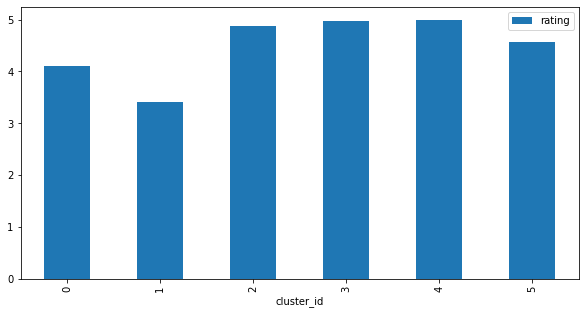

In [17]:
average_ratings = df.groupby('cluster_id').mean()

fig = average_ratings.plot.bar(figsize=(10,5))

____
Now we will plot each rating on a 2d scatter-plot. Currently, the length/dimensions of the representation vectors is more than 3000. We will use the PCA dimensionality reduction tool to reduce the number of dimensions to 2. In the [tutorials folder] (https://github.com/InfoTUNI/joda2022/tree/master/tutorials) you may find a more detailed explanation of the PCA technique. 



In [18]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components, for 2d visualising.
pca = PCA(n_components=2)

# Reduce representation vectors
reducedX = pca.fit_transform(reprs)

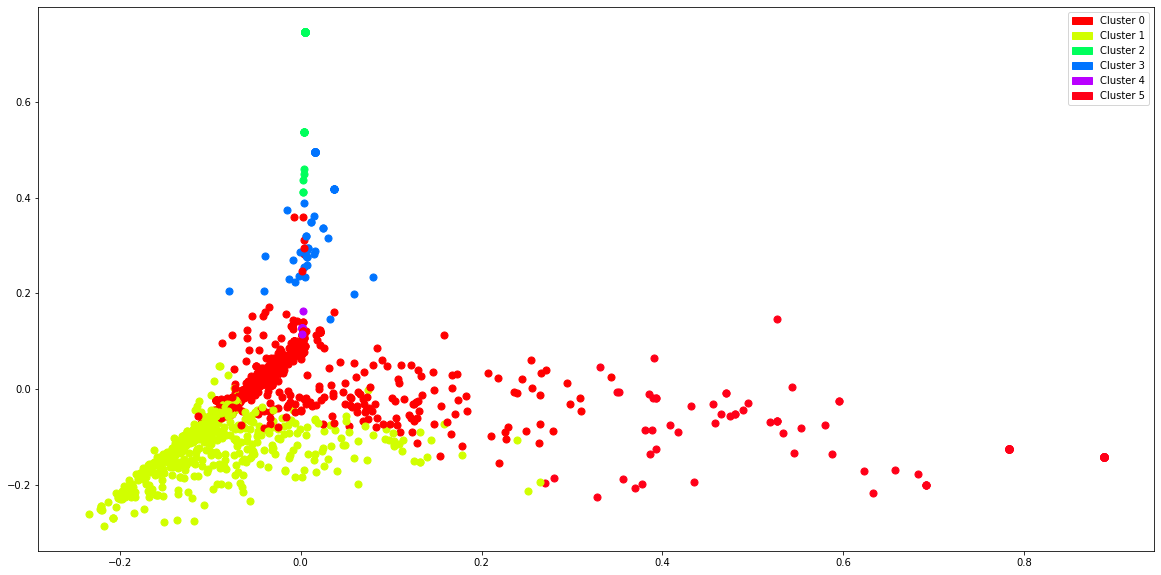

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))

# generate k colors
color_map = lambda cid: plt.cm.get_cmap('hsv', k)(cid)

for dp, cid in zip(reducedX, clusters):
    ax.scatter(dp[0], dp[1], s=50, color=color_map(cid))

    
plt.legend(handles=[
                        mpatches.Patch(color=color_map(cid), label='Cluster '+str(cid)) for cid in range(k)
        ])
plt.show()

In [23]:
df[df['cluster_id']==2]

,text,rating,cluster_id
222,excelente,5.0,2
244,excelente,5.0,2
477,excelente,5.0,2
533,excelente,4.0,2
535,excelente telefono,5.0,2
538,excelente,5.0,2
547,excelente.,4.0,2
565,excelente,5.0,2
568,excelente!!,5.0,2
600,excelente,5.0,2


In [24]:
print('Thank you')

Thank you
